# Import

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# RNN - LSTM 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# To avoid warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Bitcoin dataset 2021-02-16/2022-02-16
df = pd.read_csv("./BTC-USD.csv", parse_dates=['Date'], index_col=["Date"])

data = df["Close"]
train = data[:257]
test = data[257:]

# RNN - LSTM

Long Short-Term Memory model is a type of Recurrent Neural Network, which is able to store recent values, evaluate and filter them with the gates and hidden layers in order to have proper prediction. 

## Preprocessing 

In [3]:
from sklearn.preprocessing import MinMaxScaler

To get the acceptable values for sigmoid(0,1) and hyperbolic tanget(-1,1) functions MinMaxScaler process our values between 0 and 1.

In [4]:
scaler = MinMaxScaler()

train1 = np.array(train).reshape(-1,1)
test1 = np.array(test).reshape(-1,1)
scaler.fit(train1)

MinMaxScaler()

In [5]:
train_scaled = scaler.transform(train1)
test_scaled = scaler.transform(test1)

LSTM model requires the input data in 3D form(batch/num of samples, num of timesteps, num of features), so first we have to convert our data.

In [6]:
# Creating training sets for fitting the model

# timestep = 25 had the best model evaluation
timestep = 25

X_train = []
y_train = []

# the timestep will determine the loop range, each batch will contain timestep number of values
# with these number of values will the model predict the next value
for i in range(timestep, len(train)-timestep):
    X_train.append(train_scaled[i-timestep:i, 0])
    y_train.append(train_scaled[i, 0])

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Each batch(in all 227) has 25 values in it, which will provide the 25 recent values to predict the next one.

In [8]:
print(X_train.shape)
print(y_train.shape)

(207, 25, 1)
(207,)


## RNN model and layers

In [9]:
# Setting up our Sequential API with 4 hidden layers with 50 neuron units and 20% dropout. 
# Using "adam" optimizer and "mse" for th loss to compile the  model.

model = Sequential()

model.add(LSTM(50, input_shape=(timestep,1), return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")

In [10]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [11]:
# Fitting our model with training data
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
7/7 [==============================] - 4s 37ms/step - loss: 0.1532
Epoch 2/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0400
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0315
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0272
Epoch 5/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0237
Epoch 6/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0233
Epoch 7/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0214
Epoch 8/20
7/7 [==============================] - 0s 30ms/step - loss: 0.0215
Epoch 9/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0199
Epoch 10/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0207
Epoch 11/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0187
Epoch 12/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0182
Epoch 13/20
7/7 [==============================] - 0s 29ms/st

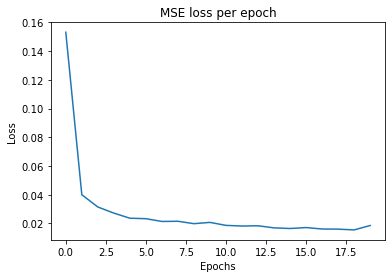

In [12]:
# Checking our loss through the epochs

epoch_loss = model.history.history["loss"]

plt.title("MSE loss per epoch")

plt.plot(range(len(epoch_loss)), epoch_loss)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [13]:
# Converting the test set for prediction
X_test = []

for i in range(timestep, len(test)):
    X_test.append(test_scaled[i-timestep:i, 0])
    
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
# Shape of the test set 
X_test.shape

(84, 25, 1)

Another way to convert our input train and test data to an acceptable 3D form for the model is using TimeseriesGenerator.

    from keras.preprocessing.sequence import TimeseriesGenerator

    train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=timestep, batch_size=20)

    test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=timestep, batch_size=1)
    
    model.fit_generator(train_gen, epochs=20)
    
    prediction_lstm = model.predict_generator(test_gen)

In [15]:
pred_lstm = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

len(pred_lstm)

84

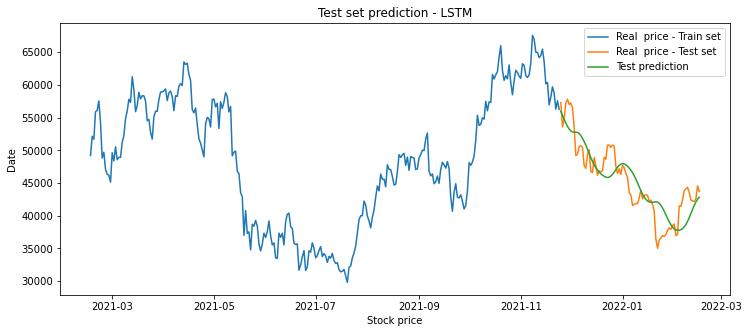

In [16]:
plt.figure(figsize=(12,5))

plt.title("Test set prediction - LSTM")
plt.xlabel("Stock price")
plt.ylabel("Date")

# len(data): 366 - (len(test): 109 - timestep) 
plt.plot(data[:len(data)-(len(test)-timestep)], label = "Real  price - Train set")
plt.plot(test.index[timestep:], test[timestep:], label = "Real  price - Test set")
plt.plot(test.index[timestep:], pred_lstm, label = "Test prediction")
         
plt.legend()

plt.show()

## Evaluate

In [17]:
rmse_lstm = mean_squared_error(test[timestep:], pred_lstm, squared=False) 

In [18]:
mape_lstm = mean_absolute_percentage_error(test[timestep:], pred_lstm)

In [19]:
print(rmse_lstm)
print(mape_lstm)

2938.144554999487
0.05266769863711422


# Forecast

For the forecast I used a different method of preparation for the model in order to have hopefully a more natural prediction.

I set not only the timestep I want to have backwards, but the forecast lenght that determines the batch size of the output as well.

In [20]:
# The method is almost the same as before

data = np.array(data).reshape(-1,1)

data_scaled = scaler.fit_transform(data)

# Setting the timestep and the forecast
timestep = 25
forecast = 50

X_train = []
y_train = []

# Here is the twist, forming the batch sizes differently like previously
for i in range(timestep, len(data) - forecast + 1):
    X_train.append(data_scaled[i - timestep: i])
    y_train.append(data_scaled[i: i + forecast])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = data_scaled[-timestep:]
X_test = X_test.reshape(1, timestep, 1)

In [21]:
# Here is how the timestep and forecast volume influence the batch sizes
print(X_train.shape)
print(y_train.shape)

(292, 25, 1)
(292, 50, 1)


In [22]:
model1 = Sequential()

model1.add(LSTM(50, input_shape=(timestep,1), return_sequences=True ))
model1.add(Dropout(0.2))

model1.add(LSTM(50, return_sequences=True ))
model1.add(Dropout(0.2))

model1.add(LSTM(50, return_sequences=True ))
model1.add(Dropout(0.2))

model1.add(LSTM(50))

# The only difference between the previous Dense layer that now we want to have forecast size output
model1.add(Dense(forecast))

model1.compile(loss="mse", optimizer="adam")

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 25, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [24]:
last_date = df.index[-1]
lstm_dates = pd.date_range(last_date, periods=forecast).tolist()

In [25]:
model1.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

final_pred_lstm = model1.predict(X_test).reshape(-1,1)
final_pred_lstm = scaler.inverse_transform(final_pred_lstm)

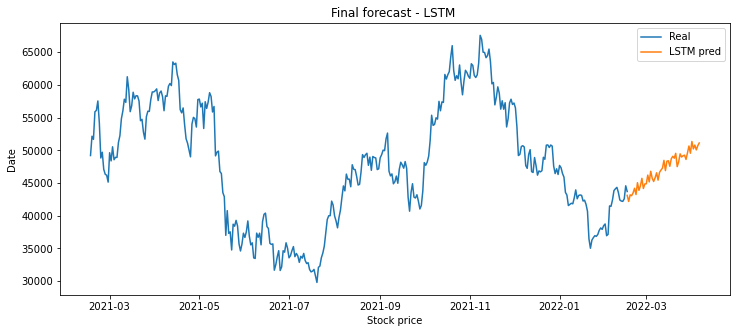

In [26]:
plt.figure(figsize=(12,5))

plt.title("Final forecast - LSTM ")
plt.xlabel("Stock price")
plt.ylabel("Date")

plt.plot(df.index, data, label="Real")
plt.plot(lstm_dates, final_pred_lstm, label="LSTM pred")

plt.legend()

plt.show()